In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, time, timedelta
from collections import defaultdict
from scipy.linalg import solve

In [2]:
df = pd.read_csv('202307-citibike-tripdata.csv')

/var/folders/g7/4mztxrt14t9btdpb6wp70tc80000gn/T/ipykernel_22515/1328114096.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('202307-citibike-tripdata.csv')


In [3]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BC78328130CD8A16,classic_bike,2023-07-16 20:42:57,2023-07-16 20:45:13,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member
1,71A4DFA231ADAEA2,classic_bike,2023-07-29 12:22:21,2023-07-29 12:26:54,Adam Clayton Powell Blvd & W 118 St,7670.09,Adam Clayton Powell Blvd & W 126 St,7738.04,40.804372,-73.951475,40.809495,-73.947765,member
2,B64451D0D9F52134,classic_bike,2023-07-30 18:30:18,2023-07-30 18:35:42,St. Nicholas Ave & W 126 St,7756.10,Lenox Ave & W 130 St,7753.13,40.811378,-73.951827,40.810792,-73.943068,member
3,EEECB3E0E05EB0DB,classic_bike,2023-07-04 19:59:20,2023-07-04 20:02:03,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member
4,76B706DF4FC180DC,classic_bike,2023-07-03 19:33:36,2023-07-03 19:43:59,St. Nicholas Ave & W 126 St,7756.10,Pleasant Ave & E 116 St,7450.05,40.811543,-73.951813,40.794988,-73.933335,member


In [4]:
# Convert the strings to datetime objects
date_format = "%Y-%m-%d %H:%M:%S"
df['started_at'] = pd.to_datetime(df['started_at'], format=date_format)
df['ended_at'] = pd.to_datetime(df['ended_at'], format=date_format)

# Calculate the time difference as a timedelta
df['ride_time'] = df['ended_at'] - df['started_at']

# Convert the time difference to minutes
df['ride_time'] = df['ride_time'].dt.total_seconds() / 60

print(df.shape)
df.head()

(3776256, 14)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time
0,BC78328130CD8A16,classic_bike,2023-07-16 20:42:57,2023-07-16 20:45:13,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member,2.266667
1,71A4DFA231ADAEA2,classic_bike,2023-07-29 12:22:21,2023-07-29 12:26:54,Adam Clayton Powell Blvd & W 118 St,7670.09,Adam Clayton Powell Blvd & W 126 St,7738.04,40.804372,-73.951475,40.809495,-73.947765,member,4.550000
2,B64451D0D9F52134,classic_bike,2023-07-30 18:30:18,2023-07-30 18:35:42,St. Nicholas Ave & W 126 St,7756.10,Lenox Ave & W 130 St,7753.13,40.811378,-73.951827,40.810792,-73.943068,member,5.400000
3,EEECB3E0E05EB0DB,classic_bike,2023-07-04 19:59:20,2023-07-04 20:02:03,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member,2.716667
4,76B706DF4FC180DC,classic_bike,2023-07-03 19:33:36,2023-07-03 19:43:59,St. Nicholas Ave & W 126 St,7756.10,Pleasant Ave & E 116 St,7450.05,40.811543,-73.951813,40.794988,-73.933335,member,10.383333


In [5]:
# Drop ride times > 3 hrs

df_final = df[df['ride_time'] < 180]
df_final = df_final.reset_index(drop=True)

# Drop ride times < 0 minutes

df_final = df_final[df_final['ride_time'] >= 0]

print(df_final.shape)
df_final.head()

(3766773, 14)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time
0,BC78328130CD8A16,classic_bike,2023-07-16 20:42:57,2023-07-16 20:45:13,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member,2.266667
1,71A4DFA231ADAEA2,classic_bike,2023-07-29 12:22:21,2023-07-29 12:26:54,Adam Clayton Powell Blvd & W 118 St,7670.09,Adam Clayton Powell Blvd & W 126 St,7738.04,40.804372,-73.951475,40.809495,-73.947765,member,4.550000
2,B64451D0D9F52134,classic_bike,2023-07-30 18:30:18,2023-07-30 18:35:42,St. Nicholas Ave & W 126 St,7756.10,Lenox Ave & W 130 St,7753.13,40.811378,-73.951827,40.810792,-73.943068,member,5.400000
3,EEECB3E0E05EB0DB,classic_bike,2023-07-04 19:59:20,2023-07-04 20:02:03,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member,2.716667
4,76B706DF4FC180DC,classic_bike,2023-07-03 19:33:36,2023-07-03 19:43:59,St. Nicholas Ave & W 126 St,7756.10,Pleasant Ave & E 116 St,7450.05,40.811543,-73.951813,40.794988,-73.933335,member,10.383333


### Warm Up Questions:

<b>1. Using the start time and end time, compute the duration of each ride in minutes and plot the histogram of ride durations.</b>

36


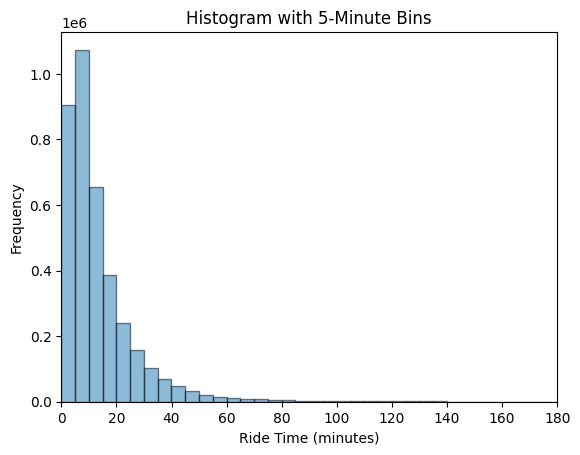

In [6]:
import matplotlib.pyplot as plt

# Calculate the number of bins
bin_size = 5
num_bins = int((max(df_final['ride_time']) - min(df_final['ride_time'])) / bin_size) + 1

print(num_bins)

# Create the histogram
plt.hist(df_final['ride_time'], bins=num_bins, edgecolor='k', alpha=0.5)

# Set labels and title
plt.xlabel('Ride Time (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram with 5-Minute Bins')

# Show the plot
plt.xlim(0, 180)
plt.show()

<b>2. What is the expected ride duration (i.e., the average ride duration)? What is the empirical variance of ride duration? What is the probability that a ride duration is greater than 20 min?</b>

In [7]:
import statistics
### Empirical Average

average = df_final['ride_time'].sum() / df_final.shape[0]

print("E (X): {}".format(average))

### Empirical Variance

variance = statistics.variance(df_final['ride_time'], xbar = average)

print("Var (X): {}".format(variance))

### P ( X > 20 )

count_greater_20 = (df_final['ride_time'] > 20).sum() 

prob_greater_20 = count_greater_20 / df_final.shape[0]

print("P (X > 20): {}".format(prob_greater_20))

E (X): 13.645103961224448
Var (X): 203.8935403213068
P (X > 20): 0.19749424772875881


<b>3. What is the probability that a ride duration is greater than 20 min conditioning on the fact that the user is a CitiBike member? Note that the last column gives whether the ride is for a casual client or a CitiBike member.</b>

In [8]:
### P ( X > 20 | User = member )

count_greater_20_member = ((df_final['ride_time'] > 20) & (df_final['member_casual'] == 'member')).sum()

count_member = (df_final['member_casual'] == 'member').sum()

prob_greater_20_member = count_greater_20_member / count_member

print("P (X > 20 | User = member): {}".format(prob_greater_20_member))

P (X > 20 | User = member): 0.15541528843070582


<b>4. Suppose that the duration of some ride is more than 25min. What is the probability that this ride belongs to a CitiBike member?</b>

In [9]:
### P ( User = member | X > 25 )

count_greater_25_member = ((df_final['ride_time'] > 25) & (df_final['member_casual'] == 'member')).sum()

count_greater_25 = (df_final['ride_time'] > 25).sum() 

prob_member_greater_25 = count_greater_25_member / count_greater_25

print("P (User = member | X > 25): {}".format(prob_member_greater_25))

P (User = member | X > 25): 0.5786827930838001


<b>5. What is the expected ride duration of an electric bike? What is the expected ride duration of a classic bike?</b>

In [10]:
### Empirical Average of Electric bike

df_electric = pd.DataFrame()

df_electric = df_final[df_final['rideable_type'] == 'electric_bike']

average_electric = df_electric['ride_time'].sum() / df_electric.shape[0]

print("E (X_electric): {}".format(average_electric))


### Empirical Average of Classic bike

df_classic = pd.DataFrame()

df_classic = pd.DataFrame(df_final[df_final['rideable_type'] == 'classic_bike'])

average_classic = df_classic['ride_time'].sum() / df_classic.shape[0]

print("E (X_classic): {}".format(average_classic))

E (X_electric): 12.275573339870734
E (X_classic): 13.726936409451845


<b>6. Suppose that the duration of some ride is less than 10min. What is the probability that this ride uses an electric bike? What is the probability that this ride uses a classic bike? Comment on the results.</b>

In [11]:
### P (Bike = electric | X < 10)

count_electric_less_10 = ((df_final['ride_time'] < 10) & (df_final['rideable_type'] == 'electric_bike')).sum()

count_less_10 = (df_final['ride_time'] < 10).sum() 

prob_electric_less_10 = count_electric_less_10 / count_less_10

print("P (Bike = electric | X < 10): {}".format(prob_electric_less_10))


### P (Bike = classic | X < 10)

count_classic_less_10 = ((df_final['ride_time'] < 10) & (df_final['rideable_type'] == 'classic_bike')).sum()

count_less_10 = (df_final['ride_time'] < 10).sum() 

prob_classic_less_10 = count_classic_less_10 / count_less_10

print("P (Bike = classic | X < 10): {}".format(prob_classic_less_10))

P (Bike = electric | X < 10): 0.08921455992944956
P (Bike = classic | X < 10): 0.9101715621826949


People used classic bikes more so than electric bikes for rides less than 10 min.

In [12]:
print("Classic: {}".format(df_classic.shape[0]))
print("Electric: {}".format(df_electric.shape[0]))

Classic: 3448285
Electric: 310011


### Project Code

In [13]:
# Selecting top 3 stations with most frequent rides in / out

df_final['start_station_name'].value_counts()

start_station_name
W 21 St & 6 Ave                                 13599
West St & Chambers St                           12976
Broadway & W 58 St                              12419
11 Ave & W 41 St                                11965
7 Ave & Central Park South                      11876
                                                ...  
2 St & Park Ave                                     1
Communipaw & Berry Lane                             1
Schenectady Ave & Cortelyou Rd                      1
Southwest Park - Jackson St & Observer Hwy          1
South Waterfront Walkway - Sinatra Dr & 1 St        1
Name: count, Length: 1936, dtype: int64

In [14]:
df_final['end_station_name'].value_counts()

end_station_name
W 21 St & 6 Ave                      13665
West St & Chambers St                13002
Broadway & W 58 St                   12035
11 Ave & W 41 St                     11977
7 Ave & Central Park South           11392
                                     ...  
Brunswick & 6th                          1
Jersey & 6th St                          1
Schenectady Ave & Cortelyou Rd           1
Van Vorst Park                           1
Columbus Park - Clinton St & 9 St        1
Name: count, Length: 1952, dtype: int64

In [15]:
len(df_final)

3766773

In [16]:
# finalized stations: need to extract only these from df_final
#'W 21 St & 6 Ave' = 6140.05
#'West St & Chambers St' = 5329.03
#'Broadway & W 58 St' = 6948.1

df_final = df_final[((df_final['start_station_name'] == 'W 21 St & 6 Ave')
                     | (df_final['start_station_name'] == 'West St & Chambers St')
                     | (df_final['start_station_name'] == 'Broadway & W 58 St')
                     | (df_final['end_station_name'] == 'W 21 St & 6 Ave')
                     | (df_final['end_station_name'] == 'West St & Chambers St')
                     | (df_final['end_station_name'] == 'Broadway & W 58 St'))]


df_final.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time
1203,1A16C593C6EB804E,classic_bike,2023-07-19 06:27:35,2023-07-19 06:31:28,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.883333
1204,136BD3B987A0F6DE,classic_bike,2023-07-31 18:16:42,2023-07-31 18:19:59,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741691,-73.994053,40.745686,-74.005141,member,3.283333
1205,6535B992A72AB451,classic_bike,2023-07-22 13:02:09,2023-07-22 13:06:21,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,4.200000
1206,316ADEF20D589A1E,classic_bike,2023-07-28 12:11:55,2023-07-28 12:15:46,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.850000
1686,C3F39D56EC95277C,classic_bike,2023-07-25 15:29:46,2023-07-25 15:32:57,W 21 St & 6 Ave,6140.05,W 17 St & 7 Ave,6107.08,40.741740,-73.994156,40.740564,-73.998526,member,3.183333


In [17]:
len(df_final)

75134

In [18]:
# Separate date and time into different columns
df_final['start_date'] = df_final['started_at'].dt.date
df_final['start_time'] = df_final['started_at'].dt.time
df_final['end_date'] = df_final['ended_at'].dt.date
df_final['end_time'] = df_final['ended_at'].dt.time

df_final.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time,start_date,start_time,end_date,end_time
1203,1A16C593C6EB804E,classic_bike,2023-07-19 06:27:35,2023-07-19 06:31:28,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.883333,2023-07-19,06:27:35,2023-07-19,06:31:28
1204,136BD3B987A0F6DE,classic_bike,2023-07-31 18:16:42,2023-07-31 18:19:59,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741691,-73.994053,40.745686,-74.005141,member,3.283333,2023-07-31,18:16:42,2023-07-31,18:19:59
1205,6535B992A72AB451,classic_bike,2023-07-22 13:02:09,2023-07-22 13:06:21,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,4.200000,2023-07-22,13:02:09,2023-07-22,13:06:21
1206,316ADEF20D589A1E,classic_bike,2023-07-28 12:11:55,2023-07-28 12:15:46,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.850000,2023-07-28,12:11:55,2023-07-28,12:15:46
1686,C3F39D56EC95277C,classic_bike,2023-07-25 15:29:46,2023-07-25 15:32:57,W 21 St & 6 Ave,6140.05,W 17 St & 7 Ave,6107.08,40.741740,-73.994156,40.740564,-73.998526,member,3.183333,2023-07-25,15:29:46,2023-07-25,15:32:57


In [19]:
# Filtering out weekends (Saturday and Sunday). Select only those rides that start on Mon, Tue, Wed, Thu or Fri.
df_final['start_date'] = pd.to_datetime(df_final['start_date'])

df_final = df_final[(df_final['start_date'].dt.weekday < 5)]

len(df_final)
df_final.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time,start_date,start_time,end_date,end_time
1203,1A16C593C6EB804E,classic_bike,2023-07-19 06:27:35,2023-07-19 06:31:28,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.883333,2023-07-19,06:27:35,2023-07-19,06:31:28
1204,136BD3B987A0F6DE,classic_bike,2023-07-31 18:16:42,2023-07-31 18:19:59,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741691,-73.994053,40.745686,-74.005141,member,3.283333,2023-07-31,18:16:42,2023-07-31,18:19:59
1206,316ADEF20D589A1E,classic_bike,2023-07-28 12:11:55,2023-07-28 12:15:46,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.850000,2023-07-28,12:11:55,2023-07-28,12:15:46
1686,C3F39D56EC95277C,classic_bike,2023-07-25 15:29:46,2023-07-25 15:32:57,W 21 St & 6 Ave,6140.05,W 17 St & 7 Ave,6107.08,40.741740,-73.994156,40.740564,-73.998526,member,3.183333,2023-07-25,15:29:46,2023-07-25,15:32:57
1689,A872FE851E458C41,classic_bike,2023-07-28 18:31:33,2023-07-28 18:45:21,W 21 St & 6 Ave,6140.05,Cleveland Pl & Spring St,5492.05,40.741740,-73.994156,40.722104,-73.997249,member,13.800000,2023-07-28,18:31:33,2023-07-28,18:45:21


In [20]:
# creation separate dataframes for each of the three stations selected
def create_station_dfs(stationid):
    dfs = df_final[((df_final['start_station_id'] == stationid)
                         | (df_final['end_station_id'] == stationid))]

    return dfs

df_station_1 = create_station_dfs("6140.05")
df_station_2 = create_station_dfs("5329.03")
df_station_3 = create_station_dfs("6948.10")

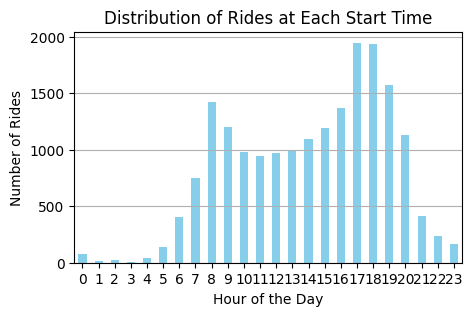

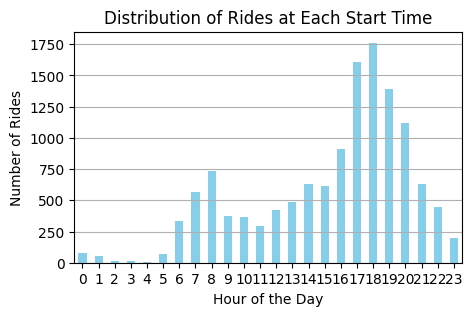

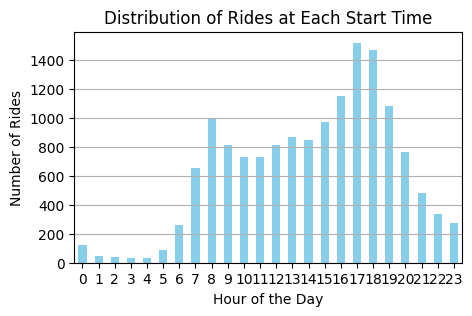

In [21]:
def distribution(df_station):

    # Function to extract hour from datetime.time object
    extract_hour = lambda x: int(x.strftime('%H'))

    # Plot the distribution of rides at each start time using a bar plot
    plt.figure(figsize=(5, 3))
    df_station['start_time'].apply(extract_hour).value_counts().sort_index().plot(kind='bar', color='skyblue')

    plt.title('Distribution of Rides at Each Start Time')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Rides')
    plt.xticks(rotation=0)
    plt.grid(axis='y')

    plt.show()
    
distribution(df_station_1)
distribution(df_station_2)
distribution(df_station_3)

In [22]:
# creation separate dataframes for each morning/evening blocks for each station

def create_time_blocked_dfs(df_station, start_time, end_time):
    
    start_time = pd.to_datetime(start_time).time()
    end_time = pd.to_datetime(end_time).time()
        

    df_station = df_station[((df_station['start_time'] >= start_time) & (df_station['end_time'] < end_time))]

    return df_station

df_station_1_morning = create_time_blocked_dfs(df_station_1, '06:00:00' , '12:00:00')
df_station_1_evening = create_time_blocked_dfs(df_station_1, '12:00:00', '22:00:00')
df_station_2_morning = create_time_blocked_dfs(df_station_2, '06:00:00' , '12:00:00')
df_station_2_evening = create_time_blocked_dfs(df_station_2, '12:00:00', '23:00:00')
df_station_3_morning = create_time_blocked_dfs(df_station_3, '06:00:00' , '12:00:00')
df_station_3_evening = create_time_blocked_dfs(df_station_3, '12:00:00', '23:00:00')

# start hrs and durations to be used in transition matrix calculation

morn_start_hr = 6
morn_duration = 6
even_start_hr = 12
even_duration = 11

In [23]:
# sorting the 6 dataframes created by start_date column

def sort_dfs(df_sm, df_se):
    df_sm = df_sm.sort_values('start_date')
    df_se = df_se.sort_values('start_date')
    return df_sm, df_se

df_station_1_morning, df_station_1_evening = sort_dfs(df_station_1_morning, df_station_1_evening)
df_station_2_morning, df_station_2_evening = sort_dfs(df_station_2_morning, df_station_2_evening)
df_station_3_morning, df_station_3_evening = sort_dfs(df_station_3_morning, df_station_3_evening)

df_station_3_morning.head()
len(df_station_1_evening)

12580

In [24]:
# creating function to define formats for dates

def datetime_format(df_sm, df_se):
    date_format = "%d/%m/%Y %H:%M"
    time_format = "%H:%M:%S"

    df_sm['start_date'] = pd.to_datetime(df_sm['start_date'], format='mixed')
    df_sm['start_time'] = pd.to_datetime(df_sm['start_time'], format=time_format)
    df_sm['end_time'] = pd.to_datetime(df_sm['end_time'], format=time_format)
    
    df_se['start_date'] = pd.to_datetime(df_se['start_date'], format='mixed')
    df_se['start_time'] = pd.to_datetime(df_se['start_time'], format=time_format)
    df_se['end_time'] = pd.to_datetime(df_se['end_time'], format=time_format)
    
    return df_sm, df_se

df_station_1_morning, df_station_1_evening = datetime_format(df_station_1_morning, df_station_1_evening)
df_station_2_morning, df_station_2_evening = datetime_format(df_station_2_morning, df_station_2_evening)
df_station_3_morning, df_station_3_evening = datetime_format(df_station_3_morning, df_station_3_evening)

df_station_3_morning.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time,start_date,start_time,end_date,end_time
1522577,DC85C42CE41F07C5,classic_bike,2023-07-03 08:36:05,2023-07-03 08:45:50,E 77 St & 1 Ave,7020.02,Broadway & W 58 St,6948.10,40.770667,-73.953592,40.766953,-73.981693,member,9.750000,2023-07-03,1900-01-01 08:36:05,2023-07-03,1900-01-01 08:45:50
1536293,FD7D8BEE17A355FC,classic_bike,2023-07-03 07:26:25,2023-07-03 07:49:17,W 47 St & 9 Ave,6786.02,Broadway & W 58 St,6948.10,40.761530,-73.990070,40.766953,-73.981693,casual,22.866667,2023-07-03,1900-01-01 07:26:25,2023-07-03,1900-01-01 07:49:17
1533769,310F455E95F53E99,classic_bike,2023-07-03 06:29:23,2023-07-03 06:41:36,Central Park W & W 97 St,7538.18,Broadway & W 58 St,6948.10,40.792495,-73.964171,40.766953,-73.981693,member,12.216667,2023-07-03,1900-01-01 06:29:23,2023-07-03,1900-01-01 06:41:36
1530804,73AFAA9FCC396AF5,classic_bike,2023-07-03 07:14:34,2023-07-03 07:26:58,W 78 St & Broadway,7311.07,Broadway & W 58 St,6948.10,40.783400,-73.980931,40.766953,-73.981693,member,12.400000,2023-07-03,1900-01-01 07:14:34,2023-07-03,1900-01-01 07:26:58
160376,5000CA61FC9B84E4,classic_bike,2023-07-03 10:33:35,2023-07-03 10:43:43,Broadway & W 58 St,6948.10,E 72 St & York Ave,6889.12,40.766736,-73.982198,40.766638,-73.953483,member,10.133333,2023-07-03,1900-01-01 10:33:35,2023-07-03,1900-01-01 10:43:43


### Data Pre-Processing Complete, Transition Matrix Calculation Start:

The purpose of the get_saturdays and count_weekends functions are to make sure that in our delta_dictionaries are continuous after the weekends. We make sure that for instance, if the last timestep of Friday July 14th is the 100th timeblock, that the first timestep of Monday July 17th would be the 101st time. Using the get_saturdays function, we find all the Saturdays in the month of July. In the count_weekends function, we calculate the number of weekends that has occured before a given date. However, since July 1st and 2nd are weekend days, we omit the first weekend, so that our dictionary starts at the first timeblock.

For example, a check done below:
July 10th occurs after 2 weekend days(counting July 8th and 9th but not 1st and 2nd).

In [42]:
def get_saturdays(year, month):
    first_day = datetime(year, month, 1)
    first_saturday = first_day + timedelta(days=(5 - first_day.weekday() + 7) % 7)
    saturdays = [first_saturday + timedelta(weeks=i) for i in range(5)]
    saturdays.pop(0)
    return saturdays

def count_weekends(date, weekends):
    weekend_counter = 0

    for i, weekend_date in enumerate(weekends):
        if date < weekend_date:
            break
        weekend_counter += 2

    return weekend_counter

year = 2023
month = 7
saturdays_july_2023 = get_saturdays(year, month)


check_date = datetime(2023, 7, 10)
weekend_count = count_weekends(check_date, saturdays_july_2023)
print(f"The date {check_date.strftime('%Y-%m-%d')} is after {weekend_count} weekend days.")

The date 2023-07-10 is after 2 weekend days.


In [43]:
# This is a copy with the new weekend counter
# creating a dictionary of deltas sorted by timestep through the time-span provided for each morning/evening block

def create_delta_dict(df, station_id, hr, duration):
    
    # count to subtract weekends from timesteps
    weekend_count = 0
    
    # number of timesteps in one day (10 minute time buckets)
    time_steps = int((duration*60)//10)
        
    # dictionary to store deltas and timesteps -> {timestep: delta}
    N_dictionary = defaultdict(int)

    # minimum date and time in the df
    min_date_time = min(min(df['started_at']), min(df['ended_at']))
    initial_day = datetime(year=min_date_time.year, month=min_date_time.month, day=min_date_time.day)
    
    # iterating through df
    for ind, row in df.iterrows():
        # start station is current station
        if row['start_station_id'] == station_id:
            weekend_count = 0
            weekend_count = count_weekends(row['start_date'], saturdays_july_2023)
            day_reference = ((row['started_at'] - initial_day).total_seconds() // (3600 * 24)) - weekend_count
            print(day_reference)

            start_time = row['started_at']

            # beginning at hr:00 on the day # predefined time for the morning or evening
            initial_time = datetime(year=start_time.year, month=start_time.month, day=start_time.day, hour=hr, minute=0, second=0)
            time_bucket = ((start_time - initial_time).total_seconds() / 60) // 10
            print(time_bucket)
            time_bucket += int(day_reference)*time_steps
            print(time_bucket)
            
            # bike is leaving if start station is current station
            N_dictionary[time_bucket] -=1

        elif row['end_station_id'] == station_id:
            weekend_count = 0
            weekend_count = count_weekends(row['start_date'], saturdays_july_2023)
            day_reference = ((row['ended_at'] - initial_day).total_seconds() // (3600 * 24)) - weekend_count

            end_time = row['ended_at']
            # predefined morning time # 7:40AM
            initial_time = datetime(year=end_time.year, month=end_time.month, day=end_time.day, hour=hr, minute=0, second=0)
            time_bucket = ((end_time - initial_time).total_seconds() / 60) // 10

            time_bucket += int(day_reference)*time_steps

            N_dictionary[time_bucket] +=1

    # sorting dictionary by time bucket
    sorted_dict = {key: N_dictionary[key] for key in sorted(N_dictionary.keys())}
    
    return sorted_dict

In [44]:
station_1_morning_dict = create_delta_dict(df_station_1_morning, '6140.05', morn_start_hr, morn_duration)
station_2_morning_dict = create_delta_dict(df_station_2_morning, '5329.03', morn_start_hr, morn_duration)
station_3_morning_dict = create_delta_dict(df_station_3_morning, '6948.10', morn_start_hr, morn_duration)

station_1_evening_dict = create_delta_dict(df_station_1_evening, '6140.05', even_start_hr, even_duration)
station_2_evening_dict = create_delta_dict(df_station_2_evening, '5329.03', even_start_hr, even_duration)
station_3_evening_dict = create_delta_dict(df_station_3_evening, '6948.10', even_start_hr, even_duration)

print(station_2_morning_dict)
print('-'*80)

0.0
23.0
23.0
0.0
32.0
32.0
0.0
27.0
27.0
0.0
9.0
9.0
0.0
14.0
14.0
0.0
16.0
16.0
0.0
31.0
31.0
0.0
13.0
13.0
0.0
29.0
29.0
0.0
32.0
32.0
0.0
10.0
10.0
0.0
24.0
24.0
0.0
31.0
31.0
0.0
26.0
26.0
0.0
24.0
24.0
0.0
14.0
14.0
0.0
32.0
32.0
0.0
26.0
26.0
0.0
25.0
25.0
0.0
31.0
31.0
0.0
24.0
24.0
0.0
19.0
19.0
0.0
32.0
32.0
0.0
24.0
24.0
0.0
28.0
28.0
0.0
34.0
34.0
0.0
3.0
3.0
0.0
26.0
26.0
0.0
34.0
34.0
0.0
26.0
26.0
0.0
19.0
19.0
0.0
23.0
23.0
0.0
23.0
23.0
0.0
18.0
18.0
0.0
21.0
21.0
0.0
16.0
16.0
0.0
31.0
31.0
0.0
16.0
16.0
0.0
13.0
13.0
0.0
17.0
17.0
0.0
26.0
26.0
0.0
4.0
4.0
0.0
24.0
24.0
0.0
31.0
31.0
0.0
14.0
14.0
0.0
27.0
27.0
0.0
29.0
29.0
0.0
14.0
14.0
0.0
27.0
27.0
0.0
30.0
30.0
0.0
24.0
24.0
0.0
28.0
28.0
0.0
35.0
35.0
0.0
31.0
31.0
0.0
29.0
29.0
0.0
29.0
29.0
0.0
31.0
31.0
0.0
21.0
21.0
0.0
24.0
24.0
0.0
20.0
20.0
0.0
19.0
19.0
0.0
16.0
16.0
0.0
15.0
15.0
0.0
20.0
20.0
0.0
26.0
26.0
1.0
33.0
69.0
1.0
26.0
62.0
1.0
28.0
64.0
1.0
12.0
48.0
1.0
19.0
55.0
1.0
13.0
49.0
1.0
32.0
68.

In [28]:
# largest delta and smallest delta in station 1
print(max(station_1_morning_dict.values()), min(station_1_morning_dict.values()))
print(station_3_morning_dict)

11 -11
{1.0: -1, 3.0: 1, 4.0: 0, 5.0: -3, 6.0: 1, 7.0: 2, 8.0: 3, 9.0: 3, 10.0: 3, 11.0: 2, 12.0: -3, 14.0: -4, 15.0: -1, 16.0: 0, 17.0: 1, 18.0: -1, 19.0: 0, 20.0: 1, 21.0: 1, 22.0: 0, 23.0: -2, 24.0: 1, 25.0: -1, 26.0: -1, 27.0: 2, 28.0: 4, 29.0: -4, 30.0: -1, 32.0: 1, 33.0: 1, 34.0: 3, 35.0: 3, 37.0: 1, 38.0: -1, 40.0: -1, 41.0: 0, 42.0: 0, 44.0: 1, 45.0: 2, 47.0: 1, 48.0: -1, 49.0: -1, 50.0: -2, 52.0: -1, 53.0: 1, 54.0: 1, 55.0: 7, 56.0: -1, 57.0: 1, 58.0: 0, 60.0: 0, 61.0: -3, 62.0: -8, 63.0: -4, 64.0: -1, 65.0: 2, 66.0: 0, 67.0: 3, 68.0: 0, 69.0: 0, 70.0: -1, 71.0: 3, 73.0: 1, 75.0: 0, 76.0: -1, 77.0: 2, 78.0: 1, 79.0: 3, 80.0: 0, 81.0: 4, 82.0: 3, 83.0: 3, 84.0: -1, 85.0: 1, 86.0: 0, 87.0: -1, 88.0: -6, 89.0: -1, 90.0: -2, 91.0: -1, 92.0: 4, 93.0: 1, 94.0: -1, 95.0: 2, 96.0: -3, 97.0: -5, 98.0: 0, 99.0: -1, 100.0: -5, 101.0: 0, 102.0: 2, 103.0: 0, 104.0: 1, 105.0: 4, 106.0: 4, 107.0: 3, 109.0: 1, 111.0: -1, 112.0: 1, 113.0: 1, 114.0: 2, 115.0: 0, 116.0: 1, 117.0: -1, 118.0: 4, 1

In [29]:
# function to impute missing values
def impute_missing_zeros(df_sm_dict, df_se_dict, duration):
    
    time_steps = int((duration*60)//10)
    min_val = int(min(df_sm_dict))
    max_val = int(max(df_se_dict))
    
    for k in range(0, min_val):
        df_sm_dict[k] = 0
    
    for k in range(max_val+1, time_steps+1):
        df_sm_dict[k] = 0
        
    df_sm_dict = {key: df_sm_dict[key] for key in sorted(df_sm_dict.keys())}
    df_se_dict = {key: df_se_dict[key] for key in sorted(df_se_dict.keys())}

    return df_sm_dict, df_se_dict

In [30]:
station_1_morning_dict, station_1_evening_dict = impute_missing_zeros(
    station_1_morning_dict, station_1_evening_dict, morn_duration)

station_2_morning_dict, station_2_evening_dict = impute_missing_zeros(
    station_2_morning_dict, station_2_evening_dict, morn_duration)

station_3_morning_dict, station_3_evening_dict = impute_missing_zeros(
    station_3_morning_dict, station_3_evening_dict, morn_duration)

In [31]:
counts = {}
for i in range(max(station_1_morning_dict.values())):
    count_local = 0
    for key in station_1_morning_dict:
        if station_1_morning_dict[key] == i:
            count_local += 1
    counts[i] = (count_local)

for i in range(0, min(station_1_morning_dict.values()), -1):
    count_local = 0
    for key in station_1_morning_dict:
        if station_1_morning_dict[key] == i:
            count_local += 1
    counts[i] = (count_local)

for key in counts:
    counts[key] = counts[key] / len(station_1_morning_dict)

sum(counts.values())

0.9959128065395095

In [32]:
def transition_matrix_func(delta_dict, N):
    """
    Creates an NXN transition matrix from given delta dictionary.
    Input:
    Output:
    """
    # initialize transition matrix
    transition_mat = [[0]* N for i in range(N)]
    # length of delta dictionary
    D = len(delta_dict)

    # finding maximum delta in the dictionary
    max_delta = max(delta_dict.values())
    min_delta = min(delta_dict.values())


    def transition_helper(transition_mat, threshold):
        """
        Augments first column and last column of the transition matrix to account for states where you cannot go to a certain delta.
        Input: Existing transition matrix
        Output: Augmented transition matrix
        """

        row_global = 0

        def last_col(transition_mat):
            # iterate through last col of the matrix
            for row in range(N):
                col = N-1
                count = 0

                for val in delta_dict.values():
                    if row + val >= N-1:
                        count += 1
                
                transition_mat[row][col] = (count/D)

            return transition_mat

        # iterate through first column of the matrix
        for row in range(N):
            col = 0
            count = 0

            # iterating through values in order to count number of deltas that do not work for this state
                # val <= -state
            for val in delta_dict.values():
                if val <= (-1*row):
                    count += 1
            
            # # if transition probability reaches a threshold, break
            # if (count / D) < threshold:
            #     row_global = row
            #     transition_mat = last_col(transition_mat)
            # inc probability of first col
            transition_mat[row][col] = (count/D)
        
        transition_mat_final = last_col(transition_mat)
    
        
        return transition_mat_final

    # counter to keep track of the number of timesteps where each delta pops up
        # {delta: # of timesteps with this delta}
    rho_counter = defaultdict(int)
    # dictionary to store transition rates
    transition_rates = {}

    # iterating through every possible delta to count occurences of each delta
    for key in delta_dict:
        delta = delta_dict[key]
        rho_counter[delta] += 1
    
    # calculating transition rates for each delta
    for d in range(min_delta, max_delta + 1):
        occurences_delta = rho_counter[d]
        transition_rates[d] = occurences_delta / D

    # filling out transition matrix
    for row in range(N):
        for col in range(N):
            # delta between the col and row in the transition matrix 
            # EX: P12 would be 2 - 1 = 1 delta
            delta_states = col - row
            if delta_states in transition_rates:
                transition_mat[row][col] = transition_rates[delta_states]
            else:
                transition_mat[row][col] = 0
    
    transition_mat = transition_helper(transition_mat, .1)

    return transition_mat

In [33]:
transition_matrix = transition_matrix_func({0:0, 1:0, 2:0, 3:1, 4:1, 5:2, 6:2, 7:3, 8:-4, 9:4}, 5)
transition_matrix

[[0.4, 0.2, 0.2, 0.1, 0.1],
 [0.1, 0.3, 0.2, 0.2, 0.2],
 [0.1, 0.0, 0.3, 0.2, 0.4],
 [0.1, 0.0, 0.0, 0.3, 0.6],
 [0.1, 0.0, 0.0, 0.0, 0.9]]

In [34]:
# Calculating stationary distribution
def calculate_stationary_distribution(transition_matrix):
    transition_mat = np.array(transition_matrix)
    n = transition_mat.shape[0]
    A = np.transpose(transition_matrix - np.eye(n))
    A[-1] = np.ones(n)
    b = np.zeros(n)
    b[-1] = 1
    stationary_distribution = solve(A,b)
    return stationary_distribution

In [35]:
station_capacity_dict = {'station_1_morning_dict': 54, 
                'station_2_morning_dict': 101, 
                'station_3_morning_dict': 52,
                'station_1_evening_dict': 54, 
                'station_2_evening_dict': 101, 
                'station_3_evening_dict': 52}


stations = [{'station_1_morning_dict': station_1_morning_dict}, {'station_2_morning_dict': station_2_morning_dict},
            {'station_3_morning_dict': station_3_morning_dict},  {'station_1_evening_dict': station_1_evening_dict}, 
            {'station_2_evening_dict': station_2_evening_dict}, {'station_3_evening_dict': station_3_evening_dict}]

for station in stations:
    for key, value in station.items():
        transition_mat = transition_matrix_func(value, station_capacity_dict[key])
        stationary_dist = calculate_stationary_distribution(transition_mat)  
        print_statement = key.split('_')
        print(f'Station {print_statement[1]} for the {print_statement[2]}: ')
        print(f'The transition matrix for {print_statement[0]} {print_statement[1]} is {np.array(transition_mat)}')
        print(f'The stationary distribution for {print_statement[0]} {print_statement[1]} is {stationary_dist}')
        print('-'*80)

Station 1 for the morning: 
The transition matrix for station 1 is [[0.40190736 0.15667575 0.14305177 ... 0.         0.         0.        ]
 [0.2506812  0.15122616 0.15667575 ... 0.         0.         0.        ]
 [0.13896458 0.11171662 0.15122616 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.15122616 0.15667575 0.44141689]
 [0.         0.         0.         ... 0.11171662 0.15122616 0.59809264]
 [0.         0.         0.         ... 0.07084469 0.11171662 0.7493188 ]]
The stationary distribution for station 1 is [1.46581885e-08 9.61103985e-09 1.37680316e-08 1.90246156e-08
 2.62101686e-08 3.61450189e-08 4.99561451e-08 6.86714720e-08
 9.44875361e-08 1.30093461e-07 1.78995075e-07 2.46390210e-07
 3.39087817e-07 4.66700365e-07 6.42322899e-07 8.84002666e-07
 1.21669311e-06 1.67450301e-06 2.30469008e-06 3.17178600e-06
 4.36633723e-06 6.00730914e-06 8.26775529e-06 1.13795767e-05
 1.56672852e-05 2.15636010e-05 2.96627895e-05 4.08462492e-05
 5.61929426e-05 7

In [36]:
def gut_check(transition_matrix, stationary_distribution):
    """
    Performs sanity checks on the transition matrix (all rows sum up to 1) & the that the stationary distribution sums up to one.
    """

    for row in range(len(transition_matrix)):
        if round(sum(transition_matrix[row]), 2) != 1.00:
            print("Invalid Transition Matrix")
    
    if round(sum(stationary_distribution), 2) != 1.00:
        print("Invalid Stationary Distribution")
    
    else:
        print("All is correct. (yippie)")

In [37]:
gut_check(transition_mat, stationary_dist)

All is correct. (yippie)


**1. Station Selection:**
    
   We identified the stations with the highest movement of bikes in and out of the station. We considered all rides with the highest counts for "start_station_id" as well as "end_station_id". Post empirical evaluations, the following stations were selected for this project:
        
   - Station 1: W 21 St & 6 Ave  
   - Station 2: West St & Chambers St  
   - Station 3: Broadway & W 58 St  

**2. Time-block Discretization:**

   We decided to discretize the time-blocks into 10-minute blocks to account for the most amount of movement between different timesteps.
   

**3. Morning/Evening Blocks Selection, Removing Weekends:**

   We removed all weekend dates from our dataset as per project guidelines. We analyzed the distributions of the rides for each station to identify two blocks of time during the 24-hr period for morning and evening blocks. As per the graphs below, we have the blocks respectively for each station.
   
   ![image.png](attachment:image.png) 
   
   ***NEED TO PASTE THE IMAGE BEFORE WE CONVERT TO PDF FOR SUBMISSION***
   
   - *Station 1:* 
       - Morning Block: 6:00 AM to 12:00 PM  
       - Evening Block: 12:00 PM to 11:00 PM
        
![image-2.png](attachment:image-2.png) 
   
   
  ***NEED TO PASTE THE IMAGE BEFORE WE CONVERT TO PDF FOR SUBMISSION***
        
   - *Station 2:* 
       - Morning Block: 6:00 AM to 12:00 PM 
       - Evening Block: 12:00 PM to 11:00 PM
    
![image-3.png](attachment:image-3.png) 
   
***NEED TO PASTE THE IMAGE BEFORE WE CONVERT TO PDF FOR SUBMISSION***
    
   - *Station 3:*  
       - Morning Block: 6:00 AM to 12:00 PM  
       - Evening Block: 12:00 PM to 11:00 PM
  
Please note that we do not consider rides in the early AM hours due to the drastic difference in distribution for every station.

**4. Number of docks (N) per station used in Transition Matrix Calculation**
   
   We have identified the number of bikes available on Google Maps for each station as of Nov 15th 2023 below:
    
   - Station 1: 54 docks  
   - Station 2: 101 docks  
   - Station 3: 52 docks

Please note that the number of bikes on Google Maps changes by 0-5 bikes on average and this is our best estimation for the total number of docks in each station.


**5. Transition Matrix Calculation**

   Add information

 - **Handling Weekends in Dataset During Calculations**
 
      Add information

**6. Stationary Distribution Calculation**

  Add information
  
  
**7. Final Insights and Summary**

 Add Information